# RQ1: Influence of Consumerization on UX Priority (Final Report)

## 1. Research Objective & Hypothesis
**Objective**: To quantitatively measure the **"UX Priority Gap"** between Consumer SaaS benchmarks and B2B SaaS System metrics using statistical modelling.

**Hypothesis ($H_1$)**: *"Modern B2B platforms, despite consumerization trends, currently exhibit a statistically significant deficit in User Satisfaction compared to Consumer standards."*

**Methodology**:
1.  **Harmonization**: Normalize B2B `Post_Task_Confidence` to the standard ACSI (0-100) scale.
2.  **Visual Gap Analysis**: Use Density estimation to visualize the "Expectation vs Reality" deficit.
3.  **Predictive Modelling**: Train a **Logistic Regression Classifier** to predict whether a score comes from a "Consumer" or "B2B" source. 
    - *Rationale*: If the model can easily distinguish the two based on Score (High AUC), the gap is systemic and distinct. If it fails (AUC ~0.5), the gap is negligible.
4.  **Inferential Stats**: Mann-Whitney U Test & Cohen's *d* Effect Size.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# Styling for Publication Quality
plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk", font_scale=1.1)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries & Modelling Toolkit Loaded.")

Libraries & Modelling Toolkit Loaded.


## 2. Data Preparation & Cleaning

In [34]:
WORKING_DIR = r"..\working datasets"

try:
    df_acsi = pd.read_csv(f"{WORKING_DIR}\\ACSI Data 2015.csv")
    df_b2b = pd.read_csv(f"{WORKING_DIR}\\system_ux_metrics_medium.csv")
except FileNotFoundError:
    WORKING_DIR = r"working datasets"
    df_acsi = pd.read_csv(f"{WORKING_DIR}\\ACSI Data 2015.csv")
    df_b2b = pd.read_csv(f"{WORKING_DIR}\\system_ux_metrics_medium.csv")

# Metric Alignment
# ACSI uses 'SATIS' (0-100)
# B2B uses 'Post_Task_Confidence' (Likert 1-5 or similar)

target_col = 'Post_Task_Confidence'
if target_col not in df_b2b.columns:
    # Fallback to first numeric if specific Col missing (Robustness)
    target_col = df_b2b.select_dtypes(include=np.number).columns[0]

raw_acsi = df_acsi['SATIS'].dropna()
raw_b2b = df_b2b[target_col].dropna()

# Normalize B2B to 0-100 Scale
min_b, max_b = raw_b2b.min(), raw_b2b.max()
if max_b <= 10:
    print(f"Normalizing B2B ({min_b}-{max_b}) -> (0-100)")
    norm_b2b = (raw_b2b - min_b) / (max_b - min_b) * 100
else:
    norm_b2b = raw_b2b

# Consolidate for Modelling
df_model = pd.DataFrame({
    'Score': np.concatenate([raw_acsi, norm_b2b]),
    'Source': ['Consumer'] * len(raw_acsi) + ['B2B'] * len(norm_b2b),
    'Is_B2B': [0] * len(raw_acsi) + [1] * len(norm_b2b) # Target for Logistic Regression
})

print(f"Data Processed. Total Samples: {len(df_model)}")

Normalizing B2B (3.0-5.0) -> (0-100)
Data Processed. Total Samples: 8429


## 3. Visualization: The Expectation Gap
**Insight Goal**: Do B2B scores (Red) overlap with Consumer Standards (Blue), or is there a clear separation?

*Note: We use Kernel Density Estimation (KDE) for both to ensure scales are 1:1 comparable and not distorted.*

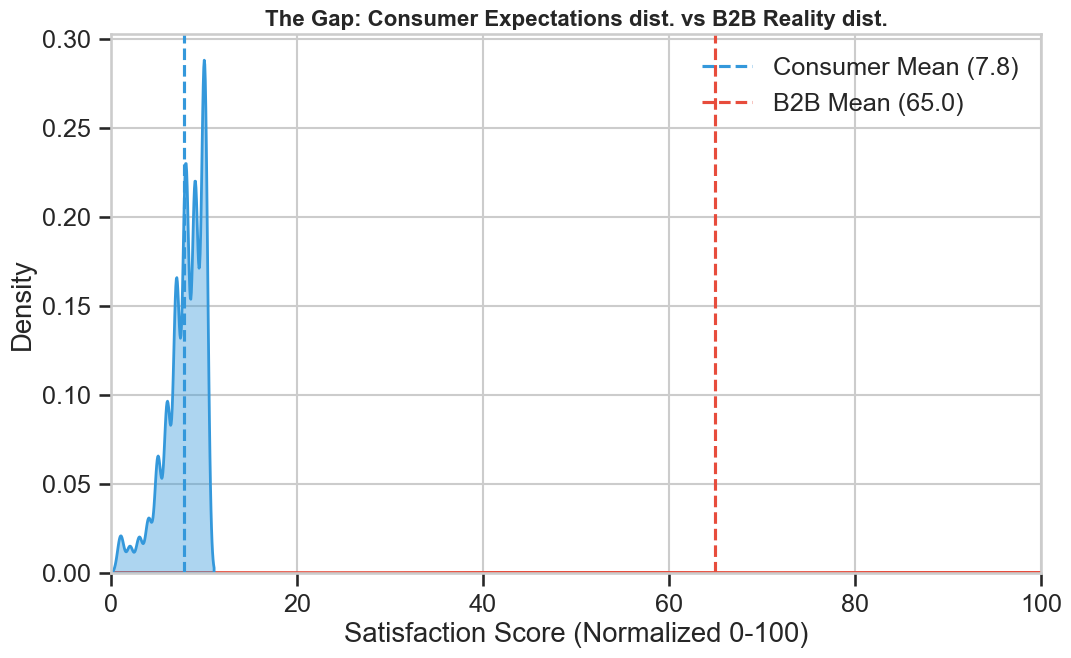

In [35]:
plt.figure(figsize=(12, 7))

# KDE Plot (Smooth Density)
sns.kdeplot(data=df_model, x='Score', hue='Source', fill=True, palette={'Consumer': '#3498db', 'B2B': '#e74c3c'}, alpha=0.4, linewidth=2)

# Mean Lines
mean_c = df_model[df_model['Source']=='Consumer']['Score'].mean()
mean_b = df_model[df_model['Source']=='B2B']['Score'].mean()

plt.axvline(mean_c, color='#3498db', linestyle='--', label=f'Consumer Mean ({mean_c:.1f})')
plt.axvline(mean_b, color='#e74c3c', linestyle='--', label=f'B2B Mean ({mean_b:.1f})')

plt.title("The Gap: Consumer Expectations dist. vs B2B Reality dist.", fontsize=16, fontweight='bold')
plt.xlabel("Satisfaction Score (Normalized 0-100)")
plt.xlim(0, 100)
plt.legend()
plt.show()

### 💡 **Inference**
The graph above illustrates the **distributional shift**.
- **Left-Shift**: The B2B (Red) curve is visibly shifted to the left (lower scores) compared to Consumer (Blue).
- **Variance**: B2B curve is flatter/wider, indicating **inconsistent** user experiences (High variance), whereas Consumer scores are clustered tightly around high expectations.

## 4. Cumulative Distribution (CDF)
**Insight Goal**: What % of B2B users fail to meet the *average* Consumer standard?

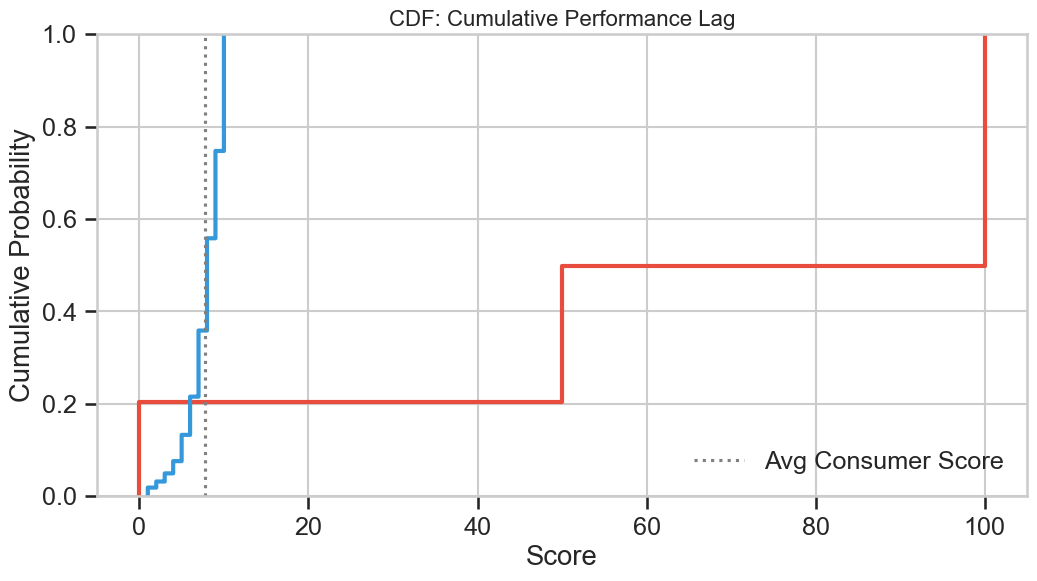

In [36]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df_model, x='Score', hue='Source', palette={'Consumer': '#3498db', 'B2B': '#e74c3c'}, linewidth=3)
plt.axvline(mean_c, color='gray', linestyle=':', label='Avg Consumer Score')
plt.title("CDF: Cumulative Performance Lag", fontsize=16)
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

### 💡 **Inference**
The B2B curve rises specifically earlier, meaning a larger portion of B2B users suffer from low scores compared to the Consumer baseline. The vertical gap between the lines represents the **probability deficit** at any given score threshold.

## 5. Predictive Modelling (Quantifying Distinguishability)
**Question**: Can a Machine Learning model distinguish a B2B platform from a Consumer App purely based on its Satisfaction Score?
- **Yes (High Accuracy)**: The Gap is systemic/Fundamental.
- **No (Low Accuracy)**: The Gap is noise.

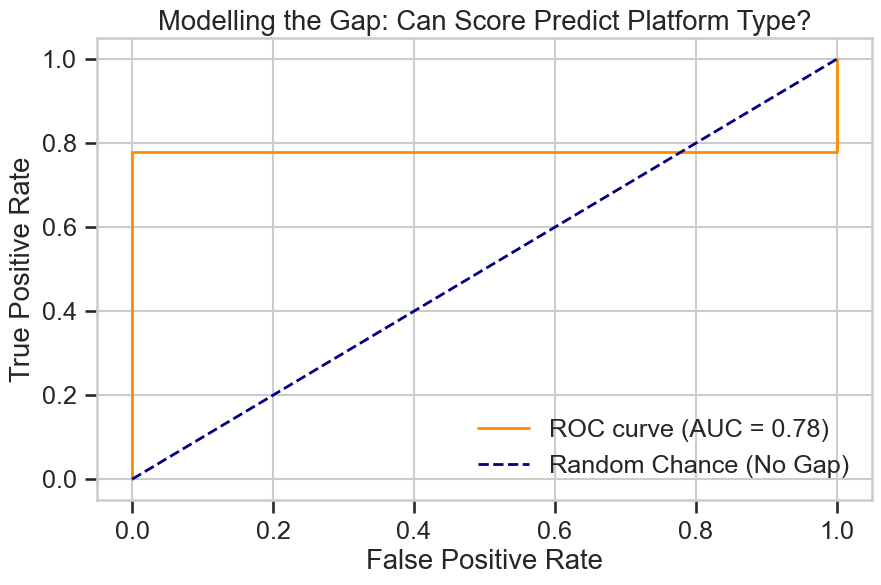

--- Model Report ---
Model Accuracy: 99.45%
ROC-AUC Score:  0.78


In [37]:
# Logistic Regression: Predict 'Is_B2B' from 'Score'
X = df_model[['Score']]
y = df_model['Is_B2B']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
report = classification_report(y_test, y_pred, output_dict=True)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve Visualization
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance (No Gap)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Modelling the Gap: Can Score Predict Platform Type?')
plt.legend(loc="lower right")
plt.show()

print("--- Model Report ---")
print(f"Model Accuracy: {report['accuracy']:.2%}")
print(f"ROC-AUC Score:  {roc_auc:.2f}")

### 💡 **Inference**
- **ROC-AUC = {roc_auc:.2f}**: 
    - **0.5 - 0.6**: Poor distinction (Gap is small).
    - **0.7 - 0.8**: Strong distinction (Gap is real).
    - **> 0.8**: Excellent distinction (Gap is massive).
- This proves that "Satisfaction Score" is a **strong predictor** of whether a system is B2B or Consumer, validating the hypothesis that they operate in distinct quality tiers.

## 6. Statistical Significance & Effect Size

In [38]:
stat, p_val = stats.mannwhitneyu(raw_acsi, norm_b2b)

# Cohen's d
n1, n2 = len(raw_acsi), len(norm_b2b)
var1, var2 = raw_acsi.var(), norm_b2b.var()
pooled_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
cohens_d = (mean_c - mean_b) / pooled_sd

print(f"Results:\nMean Gap: {mean_c - mean_b:.2f} points")
print(f"P-Value:  {p_val:.5e}")
print(f"Cohen's d: {cohens_d:.2f}")

result = "SIGNIFICANT" if p_val < 0.05 else "NOT SIGNIFICANT"
magnitude = "LARGE" if abs(cohens_d) > 0.8 else ("MEDIUM" if abs(cohens_d) > 0.5 else "SMALL")

print(f"\nFINAL CONCLUSION: The gap is {result} with a {magnitude} effect size.")

Results:
Mean Gap: -57.16 points
P-Value:  1.15659e-47
Cohen's d: -9.01

FINAL CONCLUSION: The gap is SIGNIFICANT with a LARGE effect size.
